# SME5902 - Otimização Linear II

## Implementação do Algoritmo Primal-Dual de Pontos Interiores

### Arthur Henrique Sousa Cruz - 15567289
### Walison Adrian de Oliveira - 11845282

### Profa. Maristela Oliveira dos Santos

# Sumário <a id="sumario"></a>

1. [Importações](#importacoes)
2. [Funções Auxiliares](#funcoes_aux)
3. [Algoritmo](#algoritmo)
4. [Descrição das Entradas](#entradas)
5. [Exemplos](#exemplos)

# Importações <a id="importacoes"></a>

In [1]:
import numpy
import json
import matplotlib.pyplot as plt

# Funções Auxiliares <a id="funcoes_aux"></a>

Adiciona restrição artificial

In [2]:
def add_artificial_constraint(A, b, c, operators):
    new_A = numpy.copy(A).tolist()
    new_b = numpy.copy(b).tolist()
    new_c = numpy.copy(c).tolist()
    new_operators = numpy.copy(operators).tolist()
    
    new_left_side = []
    for i in range(len(c)):
        new_left_side.append(1)
    new_A.append(new_left_side)
    
    big_M = (numpy.max(numpy.abs(new_b))) * (len(new_b))
    new_b.append(big_M)
    
    new_operators.append("<=")
    
    
    new_A = numpy.array(new_A)
    new_b = numpy.array(new_b)
    new_c = numpy.array(new_c)
    
    return (new_A, new_b, new_c, new_operators)

Conversão para Modelo Padrão

In [3]:
def convert_to_min(problem_type, c):
    if (problem_type.upper() == "MAX"):
        return (numpy.array(c) * -1).tolist()
    return c

def get_slack_sign(operator):
    if (operator == "<" or operator == "<="):
        return 1
    elif(operator == ">" or operator == ">="):
        return -1
    else:
        return 0

def convert_to_standard_form(problem_type, A, operators, c):
    new_A = numpy.copy(A)
    new_c = numpy.copy(c).tolist()
    new_c = convert_to_min(problem_type, new_c)
    for pos, operator in enumerate(operators):
        multiplier = get_slack_sign(operator)
        if (multiplier == 0):
            continue
        new_column = numpy.zeros((numpy.size(new_A, axis=0),1))
        new_column[pos, 0] = multiplier
        new_A = numpy.append(new_A, new_column, axis=1)
        new_c.append(0)

    return new_A, new_c

Converte o modelo para o formato Ax $\leq$ b e adiciona restrições x $\ge$ 0 (usado para plot. Funciona somente para duas variáveis.)

In [4]:
def convert_to_less_equal(A, operators, b):
    new_A = numpy.copy(A)
    new_b = numpy.copy(b)
    for i, operator in enumerate(operators):
        multiplier = get_slack_sign(operator)
        if (multiplier == 1):
            continue
        elif (multiplier == 0):
            new_A = numpy.append(new_A, -1 * new_A[i:i+1, :], axis=0)
            new_b = numpy.append(new_b, -1 * new_b[i])
        else:
            new_A[i] = -1*new_A[i]
            new_b[i] = -1*new_b[i]
        
    #Restricoes de nao negatividade
    new_A = numpy.append(new_A, [[-1, 0]], axis=0)
    new_b = numpy.append(new_b, 0)
    new_A = numpy.append(new_A, [[0, -1]], axis=0)
    new_b = numpy.append(new_b, 0)
    
    return new_A, new_b

Imprime modelo (formato padrão apenas)

In [5]:
def print_model(A, b, c):
        text = "*" * 80 + "\n"
        text += "MODELO NA FORMA PADRÃO:\n"
        
        # Print Objective Function
        text += "min \t"
        for i in range(len(A[0])):
            value = abs(c[i])
            if (i == 0 and c[i] < 0):
                text += "- "
            if (i == 0 and c[i] >= 0):
                text += "+ "
            text += str(value) + "x_" + str(i+1)
            if (i < len(c)-1):
                if (c[i+1] >= 0):
                    text += " + "
                else:
                    text += " - "
            else:
                text += " "
        text += "\n"
        
        text += "Subject to:\n"
        # Print Ax = b
        for i in range(len(A)):
            text += "(" + str(i+1) + ")" + "\t"
            for j in range(len(A.T)):
                value = abs(A[i][j])
                if (j == 0 and A[i][j] < 0):
                    text += "- "
                if (j == 0 and A[i][j] >= 0):
                    text += "+ "
                text += str(value) + "x_" + str(j+1)
                if (j < len(A.T)-1):
                    if (A[i][j+1] >= 0):
                        text += " + "
                    else:
                        text += " - "
                else:
                    text += " "
            text += "= "
            text += str(b[i])
            text += "\n"

        # Print x >= 0
        text += "\t"
        for i in range(len(A[0])):
            text += "x_" + str(i+1) + ">=" + "0"
            if (i < len(A[0])-1):
                text += ", "
            else:
                text += "\n"
        
        text += "*" * 80 + "\n"
        print(text)

Plota gráfico da solução (se houver)

In [6]:
def satisfies_constraints(X, Y, A, b):
        points = numpy.vstack((X.ravel(), Y.ravel())).T
        constraints = numpy.all(numpy.dot(A, points.T) <= b[:, numpy.newaxis], axis=0)
        return constraints.reshape(X.shape)

def plot_graph(input_A, b, operators, solutions_list, infeasible):

    A, b = convert_to_less_equal(input_A, operators, b)
#     x = numpy.linspace(-10, 10, 800)
#     y = numpy.linspace(-10, 10, 800)
    x = numpy.linspace(min(min(b), -2), 2*max(b), (2*max(b)-min(min(b), -2))*40)
    y = numpy.linspace(min(min(b), -2), 2*max(b), (2*max(b)-min(min(b), -2))*40)
    X, Y = numpy.meshgrid(x, y)

    #Região factível
    feasible_region = satisfies_constraints(X, Y, A, b)
    plt.figure(figsize=(8, 8))
#     plt.imshow(feasible_region, extent=(-10, 10, -10, 10), origin="lower", cmap="Greys", alpha=0.3)
    plt.imshow(feasible_region, extent=(min(min(b), -2), 2*max(b), min(min(b), -2), 2*max(b)), origin="lower", cmap="Greys", alpha=0.3)

    cores = ['#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14', '#929591','#9a0eea', '#0bf9ea', '#920a4e', '#befdb7', '#f5bf03', '#ffa62b', '#e6daa6', '#ffb07c', '#ceb301', '#000000', '#c1c6fc', '#c4fff7', '#840000', '#ff028d', '#fc5a50', '#ffffe4', '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14', '#929591','#9a0eea', '#0bf9ea', '#920a4e', '#befdb7', '#f5bf03', '#ffa62b', '#e6daa6', '#ffb07c', '#ceb301', '#000000', '#c1c6fc', '#c4fff7', '#840000', '#ff028d', '#fc5a50', '#ffffe4', '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14', '#929591','#9a0eea', '#0bf9ea', '#920a4e', '#befdb7', '#f5bf03', '#ffa62b', '#e6daa6', '#ffb07c', '#ceb301', '#000000', '#c1c6fc', '#c4fff7', '#840000', '#ff028d', '#fc5a50', '#ffffe4', '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14', '#929591','#9a0eea', '#0bf9ea', '#920a4e', '#befdb7', '#f5bf03', '#ffa62b', '#e6daa6', '#ffb07c', '#ceb301', '#000000', '#c1c6fc', '#c4fff7', '#840000', '#ff028d', '#fc5a50','#ffffe4', '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14', '#929591','#9a0eea', '#0bf9ea', '#920a4e', '#befdb7', '#f5bf03', '#ffa62b', '#e6daa6', '#ffb07c', '#ceb301', '#000000', '#c1c6fc', '#c4fff7', '#840000', '#ff028d', '#fc5a50']

    #Linhas das restricoes
    for i in range(len(A)):
        
        color = cores[i]
        
        if i >= len(A) - 2:
            
            color = 'black'
        
        if(A[i][0] == 0):
            
            text = str(A[i][1]) + "$x_2 \leq $" + str(b[i])
            plt.axvline(x=b[i]/A[i][1], label = text, color = color)
            
        elif (A[i][1] == 0):
            
            text = str(A[i][0]) + "$x_1 \leq $" + str(b[i])
            plt.axhline(y=b[i]/A[i][0], label = text, color = color)
            
        else:
            
            if (A[i][1] > 0):
                
                text = str(A[i][0]) + "$x_1 +$" + str(A[i][1]) + "$x_2 \leq $" + str(b[i])
            else:
                
                text = str(A[i][0]) + "$x_1 -$" + str(-A[i][1]) + "$x_2 \leq $" + str(b[i])
                
            plt.plot(x, (b[i] - A[i][0]*x)/A[i][1], label = text, color = color)

    #Solucoes
    for solution in solutions_list:
        plt.plot(solution["primal"][0], solution["primal"][1], 'ro', markersize=6)
        
    #Grafico
    plt.xlim(-2, 2*max(abs(b)))
    plt.ylim(-2, 2*max(abs(b)))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    
    if (infeasible):
        plt.title('Região Infactível')
    else:
        plt.title('Região Factível')
        
    plt.grid(True)

    plt.show()
    
    return

Cria dicionário contendo dados de uma solução

In [7]:
def get_solution_dict(
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    primal_errors, 
    dual_errors, 
    fo_gap
):
    return {
        "primal": primal_sol,
        "dual": dual_sol,
        "dual_slacks": dual_slacks_sol,
        "ro_P": primal_errors,
        "ro_D": dual_errors,
        "gap": fo_gap
    }


Cálculos desvios da factibilidade primal e dual, além do gap entre as funções do primal e dual. Também o cálculo do somatório das folgas complementares.

In [8]:
def calculate_primal_errors(b, A, primal_sol):
    return b - numpy.matmul(A, primal_sol)

def calculate_dual_errors(c, A, dual_sol, dual_slacks_sol):
    return c - numpy.matmul(A.T, dual_sol) - dual_slacks_sol

def calculate_fo_gap(primal_sol, dual_slacks_sol, n):
    return (numpy.matmul(primal_sol, dual_slacks_sol))/n

def calculate_complementary_slacks_sum(alfa, primal_sol, dual_slacks_sol, n):
    return alfa * (sum(primal_sol * dual_slacks_sol)/n)

Verificações de factibilidade primal e dual. Verificação de aceitação do gap. Verificação de Otimalidade

In [9]:
def primal_is_feasible(primal_errors):
    
    return numpy.linalg.norm(primal_errors, ord=numpy.inf) <= primal_max_error

def dual_is_feasible(dual_errors):
    
    return numpy.linalg.norm(dual_errors, ord=numpy.inf) <= dual_max_error

def fo_gap_is_acceptable(fo_gap):
    return fo_gap <= fo_gap_max_error

def is_optimal(primal_errors, dual_errors, fo_gap):
    return (
        primal_is_feasible(primal_errors)
        and dual_is_feasible(dual_errors)
        and fo_gap_is_acceptable(fo_gap)
    )

Cálculo do lado direito para encontrar a (direção?) solução dual ($b^{(k)}$)

In [10]:
def calculate_b(A, omega, mi, aux, primal_errors, dual_errors):
    return (
        primal_errors 
        + numpy.matmul(
            numpy.matmul(A, omega), 
            (
                dual_errors 
                + mi
                - aux
            )
        )
    )

Cálculo (da direção?) da solução dual

In [11]:
def calculate_dual_solution(A, omega, b_k):
    system_paramters = numpy.matmul(numpy.matmul(A, omega), A.T)
    return numpy.linalg.solve(system_paramters, b_k)

Cálculo (da direção?) da solução primal

In [12]:
def calculate_primal_solution(A, omega, dual_sol, dual_errors, mi, aux):
    return (
        numpy.matmul(
            omega,
            (
                numpy.matmul(A.T, dual_sol)
                - dual_errors
                - mi
                + aux
            )
        )
    )

Cálculo (da direção?) das folgas do dual

In [13]:
def calculate_slacks_dual_solution(mi, aux, omega_inv, primal_sol):
    return (
        - mi
        + aux
        - numpy.matmul(omega_inv, primal_sol)
    )

Cálculo da direção da busca

In [14]:
def calculate_direction_search(
    A, 
    X, 
    M, 
    primal_errors, 
    dual_errors, 
    slacks_errors_sum
):
    M_inv = numpy.linalg.inv(M)
    X_inv = numpy.linalg.inv(X)

    # Omega = X * M^-1
    omega = numpy.matmul(X, M_inv)
    omega_inv = numpy.matmul(X_inv, M)

    # aux = delta * X^-1 * e
    aux = (slacks_errors_sum * X_inv).diagonal()

    # b = ro_P + ((A * Omega) * (ro_D + (M * e) - delta*X^-1 * e))
    new_b = calculate_b(A, omega, M.diagonal(), aux, primal_errors, dual_errors)

    # [A Omega A^T] lambda = b
    dual_variation = calculate_dual_solution(A, omega, new_b)    
    # x = omega * (A^T lambda - ro_D - (M * e) + (delta * X^-1 * e))
    primal_variation = calculate_primal_solution(
        A, 
        omega, 
        dual_variation,
        dual_errors, 
        M.diagonal(),
        aux
    )

    # mi = - (M * e) + (delta * X^-1 * e) - (omega * x)
    dual_slacks_variation = calculate_slacks_dual_solution(
        M.diagonal(),
        aux,
        omega_inv,
        primal_variation
    )

    return (primal_variation, dual_variation, dual_slacks_variation)

Cálculo do tamanho do passo

In [15]:
def calculate_step_size(
    beta,
    last_primal_sol, 
    primal_sol, 
    last_dual_slacks_sol, 
    dual_slacks_sol
):
    possibles = [1]
    
    for i in range(n):
        if (primal_sol[i] < 0):
            possibles.append(-last_primal_sol[i]/primal_sol[i])
        if (dual_slacks_sol[i] < 0):
            possibles.append(-last_dual_slacks_sol[i]/dual_slacks_sol[i])

    return beta * min(possibles)


Atualização da solução

In [16]:
def update_solution(
    primal_sol,
    primal_var,
    dual_sol,
    dual_var,
    dual_slacks_sol,
    dual_slacks_var,
    step_size
):
    
    primal_sol = primal_sol + step_size * primal_var
    dual_sol = dual_sol + step_size * dual_var
    dual_slacks_sol = dual_slacks_sol + step_size * dual_slacks_var
    
    return (primal_sol, dual_sol, dual_slacks_sol)

# Algoritmo <a id="algoritmo"></a>

In [17]:
def solve(
    A, 
    b, 
    c, 
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    alfa, 
    beta, 
    it_max, 
    primal_max_error, 
    dual_max_error, 
    fo_gap_max_error
):

    # Initialize
    it = 0
    
    # Calculate errors for initial solution
    primal_errors = calculate_primal_errors(b, A, primal_sol) # ||ro_P||
    dual_errors = calculate_dual_errors(c, A, dual_sol, dual_slacks_sol) # ||ro_D||
    fo_gap = calculate_fo_gap(primal_sol, dual_slacks_sol, n) # x*mi/n

    # delta = alfa * sum_{i = 1...n}{x_i * mi_i}/n
    complementary_slacks_sum = calculate_complementary_slacks_sum(
        alfa,
        primal_sol, 
        dual_slacks_sol,
        n
    )

    # Add solution to solutions list
    solutions_list = [
        get_solution_dict(
            primal_sol.tolist(), 
            dual_sol.tolist(), 
            dual_slacks_sol.tolist(), 
            primal_errors.tolist(), 
            dual_errors.tolist(), 
            fo_gap
        )
    ]
    
    # Define mi and x diagonal matrices, along with e = [1, ..., 1] vector
    M = numpy.zeros(shape=(n,n))
    X = numpy.zeros(shape=(n,n))
    e = numpy.array([1] * n)
    
    # Main loop
    while (not is_optimal(primal_errors, dual_errors, fo_gap) and it < it_max):
        numpy.fill_diagonal(M, dual_slacks_sol)
        numpy.fill_diagonal(X, primal_sol)

        primal_var, dual_var, dual_slacks_var = calculate_direction_search(
            A, 
            X, 
            M, 
            primal_errors, 
            dual_errors, 
            complementary_slacks_sum
        )

        step_size = calculate_step_size(
            beta, 
            X.diagonal(), 
            primal_var,
            M.diagonal(),
            dual_slacks_var
        )

        primal_sol, dual_sol, dual_slacks_sol = updated_sol = update_solution(
            primal_sol,
            primal_var,
            dual_sol,
            dual_var,
            dual_slacks_sol,
            dual_slacks_var,
            step_size
        )

        primal_errors = calculate_primal_errors(b, A, primal_sol)
        dual_errors = calculate_dual_errors(c, A, dual_sol, dual_slacks_sol)
        fo_gap = calculate_fo_gap(primal_sol, dual_slacks_sol, n)

        solutions_list.append(
            get_solution_dict(
                primal_sol.tolist(), 
                dual_sol.tolist(), 
                dual_slacks_sol.tolist(), 
                primal_errors.tolist(), 
                dual_errors.tolist(), 
                fo_gap
            )
        )

        complementary_slacks_sum = alfa * complementary_slacks_sum

        it += 1

    infeasible = False
    unbounded = False
    gap_acceptable = True
    optimal_found = is_optimal(primal_errors, dual_errors, fo_gap)
    it_max_reached = False

#     print("primal_is_feasible(primal_errors)", primal_is_feasible(primal_errors))
#     print("dual_is_feasible(dual_errors)", dual_is_feasible(dual_errors))
#     print("fo_gap_is_acceptable(fo_gap)", fo_gap_is_acceptable(fo_gap))
#     print("is_optimal(primal_errors, dual_errors, fo_gap)", is_optimal(primal_errors, dual_errors, fo_gap))
    
    if (it == it_max and not optimal_found):
        it_max_reached = True
        if (primal_is_feasible(primal_errors) and not dual_is_feasible(dual_errors)):
            unbounded = True
        elif (primal_is_feasible(primal_errors) and dual_is_feasible(dual_errors)):
            gap_not_acceptable = False
        else:
            infeasible = True
            
    return (
        solutions_list,
        optimal_found,
        infeasible,
        unbounded,
        gap_acceptable,
        it_max_reached
    )

# Descrição das Entradas <a id="entradas"></a>

**problem_type**: se o problema de minização (min) ou maximização (max):

**input_costs**: vetor de custos (c)

**input_A**: matriz A

**operators**: operador de cada restrição (<=, >=, =)

**b**: vetor de recursos (b)

**primal_sol**: solução inicial do primal

**dual_sol**: solução inicial do dual

**dual_slacks_sol**: valores das folgas na solução dual

**Parâmetros de Entrada para o Algoritmo**

alfa: parâmetro $\alpha$

beta: parâmetro $\beta$

it_max: limite de iterações ($K_{max}$)

primal_max_error: erro máximo permitido para $Ax = b$ ($\epsilon_{P}$)

dual_max_error: erro máximo permitido para $A^{T}\lambda + \mu = c$ ($\epsilon_{D}$)

fo_gap_max_error: gap máximo para otimalidade ($f(x) - g(\lambda)$) ($\epsilon_{F}$)

# Exemplos <a id="exemplos"></a>

## Exemplo 1 (Sem Restrição Artificial)

### Definição dos dados do modelo

In [18]:
problem_type = "min"
input_costs = [-1, -2]
input_A = [
    [1, 1],
    [1, -1],
    [-1, 1]
]
input_operators = ["<", "<=", "<"]
input_b = [6, 4, 4]

### Definição do Ponto Inicial (Primal, Dual e folas do dual)

In [19]:
primal_sol = [1, 1, 4, 4, 4]
dual_sol = [0, 0, 0]
dual_slacks_sol = [1, 1, 1, 1, 1]

### Conversão para Formato Padrão <a id="conv_fp"></a>

In [20]:
primal_sol = numpy.array(primal_sol)
dual_sol = numpy.array(dual_sol)
dual_slacks_sol = numpy.array(dual_slacks_sol)

A, c = convert_to_standard_form(problem_type, input_A, input_operators, input_costs)
b = numpy.copy(input_b)

n = len(A.T)
m = len(A)

### Definição dos parâmetros constantes ($\alpha$, $\beta$, $K_{max}$, $\epsilon_{P}$, $\epsilon_{D}$, $\epsilon_{F}$):

In [21]:
alfa = 0.1
beta = 0.995
it_max = 10
primal_max_error = 0.5 * 10**(-3)
dual_max_error = 0.5 * 10**(-3)
fo_gap_max_error = 0.5 * 10**(-3)

### Print das entradas

#### Modelo no formato padrão

In [22]:
print_model(A, b, c)

********************************************************************************
MODELO NA FORMA PADRÃO:
min 	- 1x_1 - 2x_2 + 0x_3 + 0x_4 + 0x_5 
Subject to:
(1)	+ 1.0x_1 + 1.0x_2 + 1.0x_3 + 0.0x_4 + 0.0x_5 = 6
(2)	+ 1.0x_1 - 1.0x_2 + 0.0x_3 + 1.0x_4 + 0.0x_5 = 4
(3)	- 1.0x_1 + 1.0x_2 + 0.0x_3 + 0.0x_4 + 1.0x_5 = 4
	x_1>=0, x_2>=0, x_3>=0, x_4>=0, x_5>=0
********************************************************************************



#### Valores da solução Inicial

In [23]:
print("Solução inicial do primal:", primal_sol)
print("Solução inicial do dual:", dual_sol)
print("Folgas do dual:", dual_slacks_sol)

Solução inicial do primal: [1 1 4 4 4]
Solução inicial do dual: [0 0 0]
Folgas do dual: [1 1 1 1 1]


### Execução

In [24]:
solutions_list, optimal_found, infeasible, unbounded, gap_acceptable, it_max_reached = solve(
    A, 
    b, 
    c, 
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    alfa, 
    beta, 
    it_max, 
    primal_max_error, 
    dual_max_error, 
    fo_gap_max_error
)

### Saídas

In [25]:
if (it_max_reached):
    print("MÁXIMO DE ITERAÇÕES ALCANÇADAS")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)
if (optimal_found):
    print("SOLUÇÃO ÓTIMA ENCONTRADA")
elif (unbounded):
    print("SOLUÇÃO ILIMITADA")
elif (infeasible):
    print("SOLUÇÃO INFACTíVEL")
elif (not gap_acceptable):
    print("PRIMAL E DUAL FACTÍVEIS.")
    print("ERRO DO GAP MAIOR QUE ACEITÀVEL.")
elif (not it_max_reached):
    print("ERRO, SITUAÇÃO DA SOLUÇÃO NÃO IDENTIFICADA.")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)

SOLUÇÃO ÓTIMA ENCONTRADA


#### Escrita do conjunto de todas as soluções

In [26]:
# # Print all solutions found
# for i, solution in enumerate(solutions_list):
#     print("---------")
#     print("k =", i)
#     print(json.dumps(solution, indent=4))

#### Plot

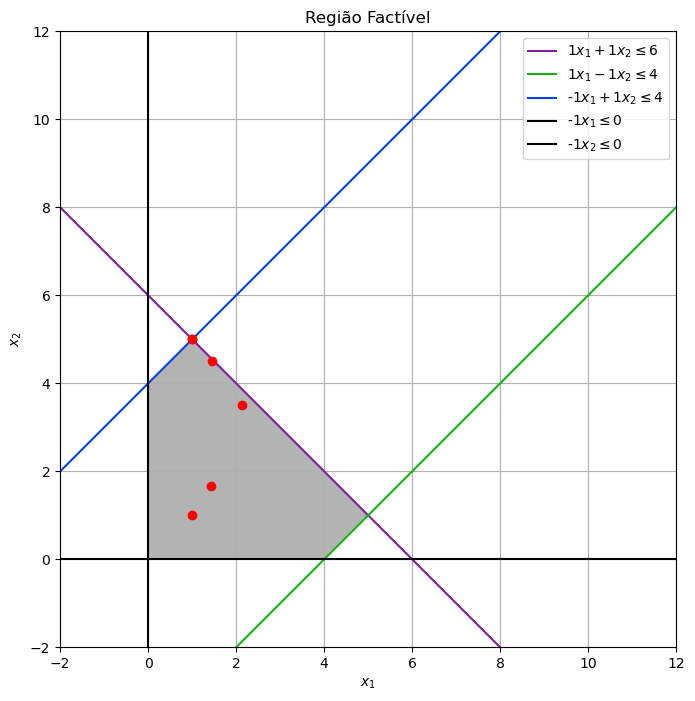

In [27]:
plot_graph(input_A, input_b, input_operators, solutions_list, infeasible)

## Exemplo 1 (Com Restrição Artificial)

### Definição dos dados do modelo

In [28]:
problem_type = "min"
input_costs = [-1, -2]
input_A = [
    [1, 1],
    [1, -1],
    [-1, 1]
]
input_operators = ["<", "<=", "<"]
input_b = [6, 4, 4]

### Definição do Ponto Inicial (Primal, Dual e folas do dual)

In [29]:
primal_sol = [1, 1, 4, 4, 4]
dual_sol = [0, 0, 0]
dual_slacks_sol = [1, 1, 1, 1, 1]

### Conversão para Formato Padrão <a id="conv_fp"></a>

In [30]:
artificial_A, artificial_b, artificial_c, artificial_operators = add_artificial_constraint(
    input_A, 
    input_b, 
    input_costs, 
    input_operators
)
# Valor da variável de folga primal referente à restrição artificial
primal_sol.append(1)
# Valor da variável dual referente à restrição artificial
dual_sol.append(0)
# Valor da variável de folga dual referente à restrição artificial
dual_slacks_sol.append(1)

primal_sol = numpy.array(primal_sol)
dual_sol = numpy.array(dual_sol)
dual_slacks_sol = numpy.array(dual_slacks_sol)

A, c = convert_to_standard_form(problem_type, artificial_A, artificial_operators, artificial_c)
b = numpy.copy(artificial_b)

n = len(A.T)
m = len(A)

### Definição dos parâmetros constantes ($\alpha$, $\beta$, $K_{max}$, $\epsilon_{P}$, $\epsilon_{D}$, $\epsilon_{F}$):

In [31]:
alfa = 0.1
beta = 0.995
it_max = 20
primal_max_error = 0.5 * 10**(-3)
dual_max_error = 0.5 * 10**(-3)
fo_gap_max_error = 0.5 * 10**(-3)

### Print das entradas

#### Modelo no formato padrão

In [32]:
print_model(A, b, c)

********************************************************************************
MODELO NA FORMA PADRÃO:
min 	- 1x_1 - 2x_2 + 0x_3 + 0x_4 + 0x_5 + 0x_6 
Subject to:
(1)	+ 1.0x_1 + 1.0x_2 + 1.0x_3 + 0.0x_4 + 0.0x_5 + 0.0x_6 = 6
(2)	+ 1.0x_1 - 1.0x_2 + 0.0x_3 + 1.0x_4 + 0.0x_5 + 0.0x_6 = 4
(3)	- 1.0x_1 + 1.0x_2 + 0.0x_3 + 0.0x_4 + 1.0x_5 + 0.0x_6 = 4
(4)	+ 1.0x_1 + 1.0x_2 + 0.0x_3 + 0.0x_4 + 0.0x_5 + 1.0x_6 = 18
	x_1>=0, x_2>=0, x_3>=0, x_4>=0, x_5>=0, x_6>=0
********************************************************************************



#### Valores da solução Inicial

In [33]:
print("Solução inicial do primal:", primal_sol)
print("Solução inicial do dual:", dual_sol)
print("Folgas do dual:", dual_slacks_sol)

Solução inicial do primal: [1 1 4 4 4 1]
Solução inicial do dual: [0 0 0 0]
Folgas do dual: [1 1 1 1 1 1]


### Execução

In [34]:
solutions_list, optimal_found, infeasible, unbounded, gap_acceptable, it_max_reached = solve(
    A, 
    b, 
    c, 
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    alfa, 
    beta, 
    it_max, 
    primal_max_error, 
    dual_max_error, 
    fo_gap_max_error
)

### Saídas

In [35]:
if (it_max_reached):
    print("MÁXIMO DE ITERAÇÕES ALCANÇADAS")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)
if (optimal_found):
    print("SOLUÇÃO ÓTIMA ENCONTRADA")
elif (unbounded):
    print("SOLUÇÃO ILIMITADA")
elif (infeasible):
    print("SOLUÇÃO INFACTíVEL")
elif (not gap_acceptable):
    print("PRIMAL E DUAL FACTÍVEIS.")
    print("ERRO DO GAP MAIOR QUE ACEITÀVEL.")
elif (not it_max_reached):
    print("ERRO, SITUAÇÃO DA SOLUÇÃO NÃO IDENTIFICADA.")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)

SOLUÇÃO ÓTIMA ENCONTRADA


#### Escrita do conjunto de todas as soluções

In [36]:
# # Print all solutions found
# for i, solution in enumerate(solutions_list):
#     print("---------")
#     print("k =", i)
#     print(json.dumps(solution, indent=4))

#### Plot

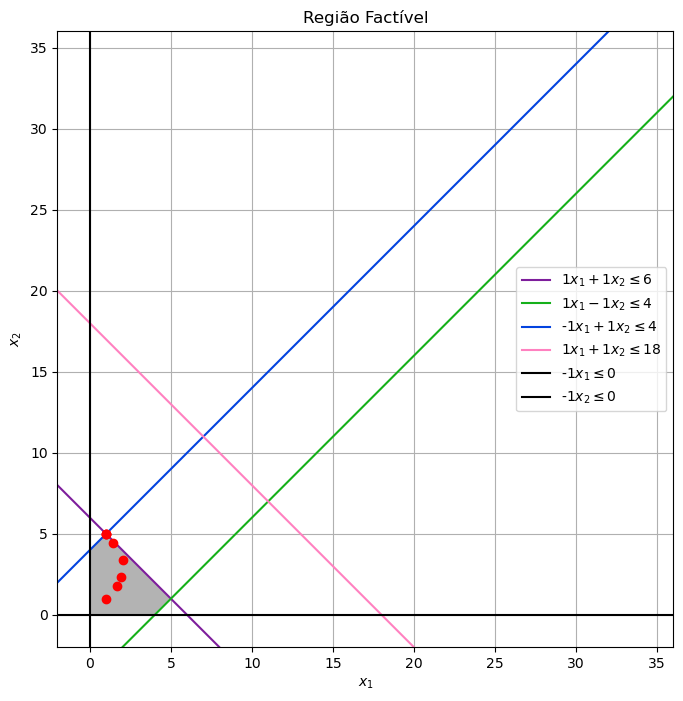

In [37]:
plot_graph(artificial_A, artificial_b, artificial_operators, solutions_list, infeasible)

## Exemplo 2 (Sem Restrição Artificial -- 6 iterações)

### Definição dos dados do modelo

In [38]:
problem_type = "min"
input_costs = [-1, -1]
input_A = [
    [1, -1],
    [-1, 1]
]
input_operators = ["<=", "<="]
input_b = [4, 4]

### Definição do Ponto Inicial (Primal, Dual e folas do dual)

In [39]:
primal_sol = [1, 1, 4, 4]
dual_sol = [0, 0]
dual_slacks_sol = [1, 1, 1, 1]

### Conversão para Formato Padrão <a id="conv_fp"></a>

In [40]:
primal_sol = numpy.array(primal_sol)
dual_sol = numpy.array(dual_sol)
dual_slacks_sol = numpy.array(dual_slacks_sol)

A, c = convert_to_standard_form(problem_type, input_A, input_operators, input_costs)
b = numpy.copy(input_b)

n = len(A.T)
m = len(A)

### Definição dos parâmetros constantes ($\alpha$, $\beta$, $K_{max}$, $\epsilon_{P}$, $\epsilon_{D}$, $\epsilon_{F}$):

In [41]:
alfa = 0.1
beta = 0.995
it_max = 6
primal_max_error = 0.5 * 10**(-3)
dual_max_error = 0.5 * 10**(-3)
fo_gap_max_error = 0.5 * 10**(-3)

### Print das entradas

#### Modelo no formato padrão

In [42]:
print_model(A, b, c)

********************************************************************************
MODELO NA FORMA PADRÃO:
min 	- 1x_1 - 1x_2 + 0x_3 + 0x_4 
Subject to:
(1)	+ 1.0x_1 - 1.0x_2 + 1.0x_3 + 0.0x_4 = 4
(2)	- 1.0x_1 + 1.0x_2 + 0.0x_3 + 1.0x_4 = 4
	x_1>=0, x_2>=0, x_3>=0, x_4>=0
********************************************************************************



#### Valores da solução Inicial

In [43]:
print("Solução inicial do primal:", primal_sol)
print("Solução inicial do dual:", dual_sol)
print("Folgas do dual:", dual_slacks_sol)

Solução inicial do primal: [1 1 4 4]
Solução inicial do dual: [0 0]
Folgas do dual: [1 1 1 1]


### Execução

In [44]:
solutions_list, optimal_found, infeasible, unbounded, gap_acceptable, it_max_reached = solve(
    A, 
    b, 
    c, 
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    alfa, 
    beta, 
    it_max, 
    primal_max_error, 
    dual_max_error, 
    fo_gap_max_error
)

### Saídas

In [45]:
if (it_max_reached):
    print("MÁXIMO DE ITERAÇÕES ALCANÇADAS")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)
if (optimal_found):
    print("SOLUÇÃO ÓTIMA ENCONTRADA")
elif (unbounded):
    print("SOLUÇÃO ILIMITADA")
elif (infeasible):
    print("SOLUÇÃO INFACTíVEL")
elif (not gap_acceptable):
    print("PRIMAL E DUAL FACTÍVEIS.")
    print("ERRO DO GAP MAIOR QUE ACEITÀVEL.")
elif (not it_max_reached):
    print("ERRO, SITUAÇÃO DA SOLUÇÃO NÃO IDENTIFICADA.")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)

MÁXIMO DE ITERAÇÕES ALCANÇADAS
ÓTIMO =  False
ILIMITADA =  True
INFACTÍVEL =  False
ERRO DO GAP ACEITÁVEL =  True
SOLUÇÃO ILIMITADA


#### Escrita do conjunto de todas as soluções

In [46]:
# # Print all solutions found
# for i, solution in enumerate(solutions_list):
#     print("---------")
#     print("k =", i)
#     print(json.dumps(solution, indent=4))

#### Plot

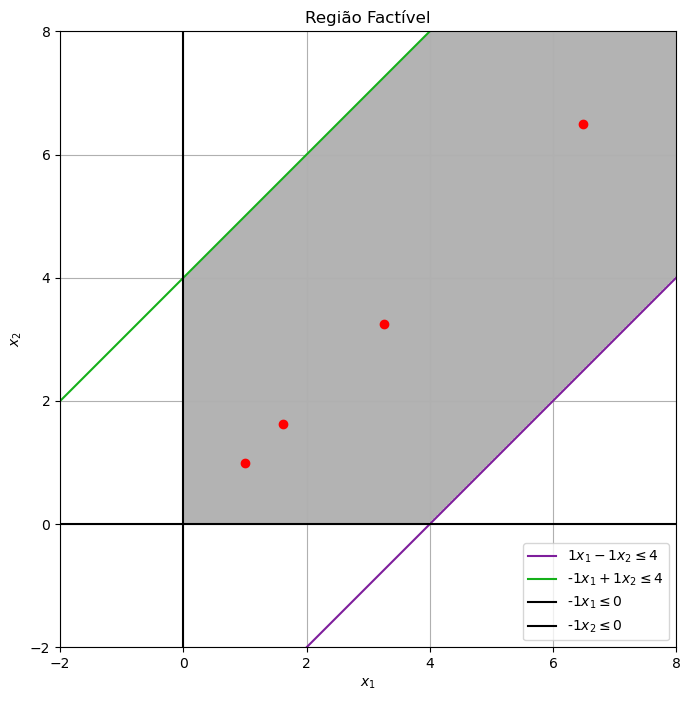

In [47]:
plot_graph(input_A, input_b, input_operators, solutions_list, infeasible)

## Exemplo 2 (Com Restrição Artificial)

### Definição dos dados do modelo

In [48]:
problem_type = "min"
input_costs = [-1, -1]
input_A = [
    [1, -1],
    [-1, 1]
]
input_operators = ["<=", "<="]
input_b = [4, 4]

### Definição do Ponto Inicial (Primal, Dual e folas do dual)

In [49]:
primal_sol = [1, 1, 4, 4]
dual_sol = [0, 0]
dual_slacks_sol = [1, 1, 1, 1]

### Conversão para Formato Padrão <a id="conv_fp"></a>

In [50]:
artificial_A, artificial_b, artificial_c, artificial_operators = add_artificial_constraint(
    input_A, 
    input_b, 
    input_costs, 
    input_operators
)
# Valor da variável de folga primal referente à restrição artificial
primal_sol.append(1)
# Valor da variável dual referente à restrição artificial
dual_sol.append(0)
# Valor da variável de folga dual referente à restrição artificial
dual_slacks_sol.append(1)

primal_sol = numpy.array(primal_sol)
dual_sol = numpy.array(dual_sol)
dual_slacks_sol = numpy.array(dual_slacks_sol)

A, c = convert_to_standard_form(problem_type, artificial_A, artificial_operators, artificial_c)
b = numpy.copy(artificial_b)

n = len(A.T)
m = len(A)

### Definição dos parâmetros constantes ($\alpha$, $\beta$, $K_{max}$, $\epsilon_{P}$, $\epsilon_{D}$, $\epsilon_{F}$):

In [51]:
alfa = 0.1
beta = 0.995
it_max = 10
primal_max_error = 0.5 * 10**(-3)
dual_max_error = 0.5 * 10**(-3)
fo_gap_max_error = 0.5 * 10**(-3)

### Print das entradas

#### Modelo no formato padrão

In [52]:
print_model(A, b, c)

********************************************************************************
MODELO NA FORMA PADRÃO:
min 	- 1x_1 - 1x_2 + 0x_3 + 0x_4 + 0x_5 
Subject to:
(1)	+ 1.0x_1 - 1.0x_2 + 1.0x_3 + 0.0x_4 + 0.0x_5 = 4
(2)	- 1.0x_1 + 1.0x_2 + 0.0x_3 + 1.0x_4 + 0.0x_5 = 4
(3)	+ 1.0x_1 + 1.0x_2 + 0.0x_3 + 0.0x_4 + 1.0x_5 = 8
	x_1>=0, x_2>=0, x_3>=0, x_4>=0, x_5>=0
********************************************************************************



#### Valores da solução Inicial

In [53]:
print("Solução inicial do primal:", primal_sol)
print("Solução inicial do dual:", dual_sol)
print("Folgas do dual:", dual_slacks_sol)

Solução inicial do primal: [1 1 4 4 1]
Solução inicial do dual: [0 0 0]
Folgas do dual: [1 1 1 1 1]


### Execução

In [54]:
solutions_list, optimal_found, infeasible, unbounded, gap_acceptable, it_max_reached = solve(
    A, 
    b, 
    c, 
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    alfa, 
    beta, 
    it_max, 
    primal_max_error, 
    dual_max_error, 
    fo_gap_max_error
)

### Saídas

In [55]:
if (it_max_reached):
    print("MÁXIMO DE ITERAÇÕES ALCANÇADAS")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)
if (optimal_found):
    print("SOLUÇÃO ÓTIMA ENCONTRADA")
elif (unbounded):
    print("SOLUÇÃO ILIMITADA")
elif (infeasible):
    print("SOLUÇÃO INFACTíVEL")
elif (not gap_acceptable):
    print("PRIMAL E DUAL FACTÍVEIS.")
    print("ERRO DO GAP MAIOR QUE ACEITÀVEL.")
elif (not it_max_reached):
    print("ERRO, SITUAÇÃO DA SOLUÇÃO NÃO IDENTIFICADA.")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)

SOLUÇÃO ÓTIMA ENCONTRADA


#### Escrita do conjunto de todas as soluções

In [56]:
# # Print all solutions found
# for i, solution in enumerate(solutions_list):
#     print("---------")
#     print("k =", i)
#     print(json.dumps(solution, indent=4))

#### Plot

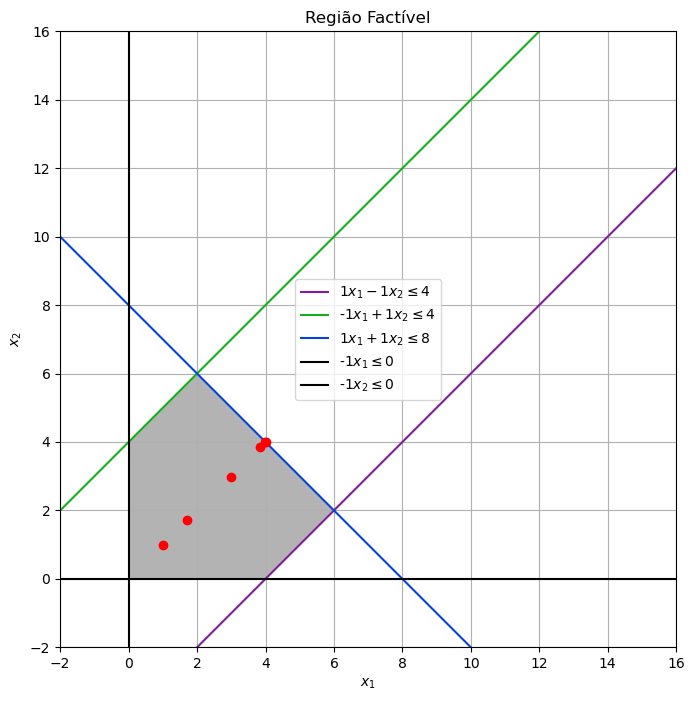

In [57]:
plot_graph(artificial_A, artificial_b, artificial_operators, solutions_list, infeasible)

## Exemplo 3 (Sem Restrição Artificial)

### Definição dos dados do modelo

In [58]:
problem_type = "min"

input_costs = [1, 1]

input_A = [
    [1, 1],
    [2, 1]
]

input_operators = [">=", "<="]

input_b = [4, 3]

### Definição do Ponto Inicial (Primal, Dual e folas do dual)

In [59]:
primal_sol = [1, 1, 4, 4]
dual_sol = [0, 0]
dual_slacks_sol = [1, 1, 1, 1]

### Conversão para Formato Padrão <a id="conv_fp"></a>

In [60]:
primal_sol = numpy.array(primal_sol)
dual_sol = numpy.array(dual_sol)
dual_slacks_sol = numpy.array(dual_slacks_sol)

A, c = convert_to_standard_form(problem_type, input_A, input_operators, input_costs)
b = numpy.copy(input_b)

n = len(A.T)
m = len(A)

### Definição dos parâmetros constantes ($\alpha$, $\beta$, $K_{max}$, $\epsilon_{P}$, $\epsilon_{D}$, $\epsilon_{F}$):

In [61]:
alfa = 0.1
beta = 0.995
it_max = 10
primal_max_error = 0.5 * 10**(-3)
dual_max_error = 0.5 * 10**(-3)
fo_gap_max_error = 0.5 * 10**(-3)

### Print das entradas

#### Modelo no formato padrão

In [62]:
print_model(A, b, c)

********************************************************************************
MODELO NA FORMA PADRÃO:
min 	+ 1x_1 + 1x_2 + 0x_3 + 0x_4 
Subject to:
(1)	+ 1.0x_1 + 1.0x_2 - 1.0x_3 + 0.0x_4 = 4
(2)	+ 2.0x_1 + 1.0x_2 + 0.0x_3 + 1.0x_4 = 3
	x_1>=0, x_2>=0, x_3>=0, x_4>=0
********************************************************************************



#### Valores da solução Inicial

In [63]:
print("Solução inicial do primal:", primal_sol)
print("Solução inicial do dual:", dual_sol)
print("Folgas do dual:", dual_slacks_sol)

Solução inicial do primal: [1 1 4 4]
Solução inicial do dual: [0 0]
Folgas do dual: [1 1 1 1]


### Execução

In [64]:
solutions_list, optimal_found, infeasible, unbounded, gap_acceptable, it_max_reached = solve(
    A, 
    b, 
    c, 
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    alfa, 
    beta, 
    it_max, 
    primal_max_error, 
    dual_max_error, 
    fo_gap_max_error
)

### Saídas

In [65]:
if (it_max_reached):
    print("MÁXIMO DE ITERAÇÕES ALCANÇADAS")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)
if (optimal_found):
    print("SOLUÇÃO ÓTIMA ENCONTRADA")
elif (unbounded):
    print("SOLUÇÃO ILIMITADA")
elif (infeasible):
    print("SOLUÇÃO INFACTíVEL")
elif (not gap_acceptable):
    print("PRIMAL E DUAL FACTÍVEIS.")
    print("ERRO DO GAP MAIOR QUE ACEITÀVEL.")
elif (not it_max_reached):
    print("ERRO, SITUAÇÃO DA SOLUÇÃO NÃO IDENTIFICADA.")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)

MÁXIMO DE ITERAÇÕES ALCANÇADAS
ÓTIMO =  False
ILIMITADA =  False
INFACTÍVEL =  True
ERRO DO GAP ACEITÁVEL =  True
SOLUÇÃO INFACTíVEL


#### Escrita do conjunto de todas as soluções

In [66]:
# # Print all solutions found
# for i, solution in enumerate(solutions_list):
#     print("---------")
#     print("k =", i)
#     print(json.dumps(solution, indent=4))

#### Plot

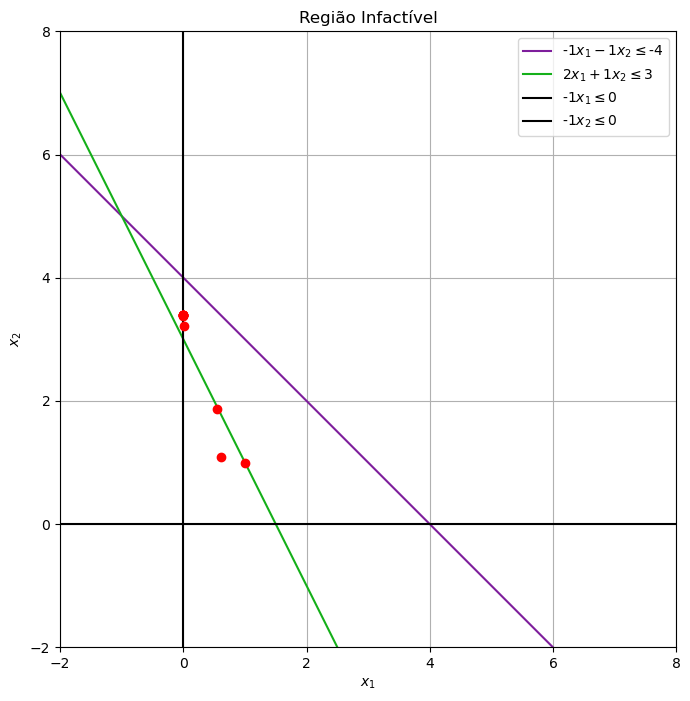

In [67]:
plot_graph(input_A, input_b, input_operators, solutions_list, infeasible)

## Exemplo 3

### Definição dos dados do modelo

In [68]:
problem_type = "min"

input_costs = [1, 1]

input_A = [
    [1, 1],
    [2, 1]
]

input_operators = [">=", "<="]

input_b = [4, 3]

### Definição do Ponto Inicial (Primal, Dual e folas do dual)

In [69]:
primal_sol = [1, 1, 4, 4]
dual_sol = [0, 0]
dual_slacks_sol = [1, 1, 1, 1]

### Conversão para Formato Padrão <a id="conv_fp"></a>

In [70]:
artificial_A, artificial_b, artificial_c, artificial_operators = add_artificial_constraint(
    input_A, 
    input_b, 
    input_costs, 
    input_operators
)
# Valor da variável de folga primal referente à restrição artificial
primal_sol.append(1)
# Valor da variável dual referente à restrição artificial
dual_sol.append(0)
# Valor da variável de folga dual referente à restrição artificial
dual_slacks_sol.append(1)

primal_sol = numpy.array(primal_sol)
dual_sol = numpy.array(dual_sol)
dual_slacks_sol = numpy.array(dual_slacks_sol)

A, c = convert_to_standard_form(problem_type, artificial_A, artificial_operators, artificial_c)
b = numpy.copy(artificial_b)

n = len(A.T)
m = len(A)

### Definição dos parâmetros constantes ($\alpha$, $\beta$, $K_{max}$, $\epsilon_{P}$, $\epsilon_{D}$, $\epsilon_{F}$):

In [71]:
alfa = 0.1
beta = 0.995
it_max = 10
primal_max_error = 0.5 * 10**(-3)
dual_max_error = 0.5 * 10**(-3)
fo_gap_max_error = 0.5 * 10**(-3)

### Print das entradas

#### Modelo no formato padrão

In [72]:
print_model(A, b, c)

********************************************************************************
MODELO NA FORMA PADRÃO:
min 	+ 1x_1 + 1x_2 + 0x_3 + 0x_4 + 0x_5 
Subject to:
(1)	+ 1.0x_1 + 1.0x_2 - 1.0x_3 + 0.0x_4 + 0.0x_5 = 4
(2)	+ 2.0x_1 + 1.0x_2 + 0.0x_3 + 1.0x_4 + 0.0x_5 = 3
(3)	+ 1.0x_1 + 1.0x_2 + 0.0x_3 + 0.0x_4 + 1.0x_5 = 8
	x_1>=0, x_2>=0, x_3>=0, x_4>=0, x_5>=0
********************************************************************************



#### Valores da solução Inicial

In [73]:
print("Solução inicial do primal:", primal_sol)
print("Solução inicial do dual:", dual_sol)
print("Folgas do dual:", dual_slacks_sol)

Solução inicial do primal: [1 1 4 4 1]
Solução inicial do dual: [0 0 0]
Folgas do dual: [1 1 1 1 1]


### Execução

In [74]:
solutions_list, optimal_found, infeasible, unbounded, gap_acceptable, it_max_reached = solve(
    A, 
    b, 
    c, 
    primal_sol, 
    dual_sol, 
    dual_slacks_sol, 
    alfa, 
    beta, 
    it_max, 
    primal_max_error, 
    dual_max_error, 
    fo_gap_max_error
)

### Saídas

In [75]:
if (it_max_reached):
    print("MÁXIMO DE ITERAÇÕES ALCANÇADAS")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)
if (optimal_found):
    print("SOLUÇÃO ÓTIMA ENCONTRADA")
elif (unbounded):
    print("SOLUÇÃO ILIMITADA")
elif (infeasible):
    print("SOLUÇÃO INFACTíVEL")
elif (not gap_acceptable):
    print("PRIMAL E DUAL FACTÍVEIS.")
    print("ERRO DO GAP MAIOR QUE ACEITÀVEL.")
elif (not it_max_reached):
    print("ERRO, SITUAÇÃO DA SOLUÇÃO NÃO IDENTIFICADA.")
    print("ÓTIMO = ", optimal_found)
    print("ILIMITADA = ", unbounded)
    print("INFACTÍVEL = ", infeasible)
    print("ERRO DO GAP ACEITÁVEL = ", gap_acceptable)

MÁXIMO DE ITERAÇÕES ALCANÇADAS
ÓTIMO =  False
ILIMITADA =  False
INFACTÍVEL =  True
ERRO DO GAP ACEITÁVEL =  True
SOLUÇÃO INFACTíVEL


#### Escrita do conjunto de todas as soluções

In [76]:
# # Print all solutions found
# for i, solution in enumerate(solutions_list):
#     print("---------")
#     print("k =", i)
#     print(json.dumps(solution, indent=4))

#### Plot

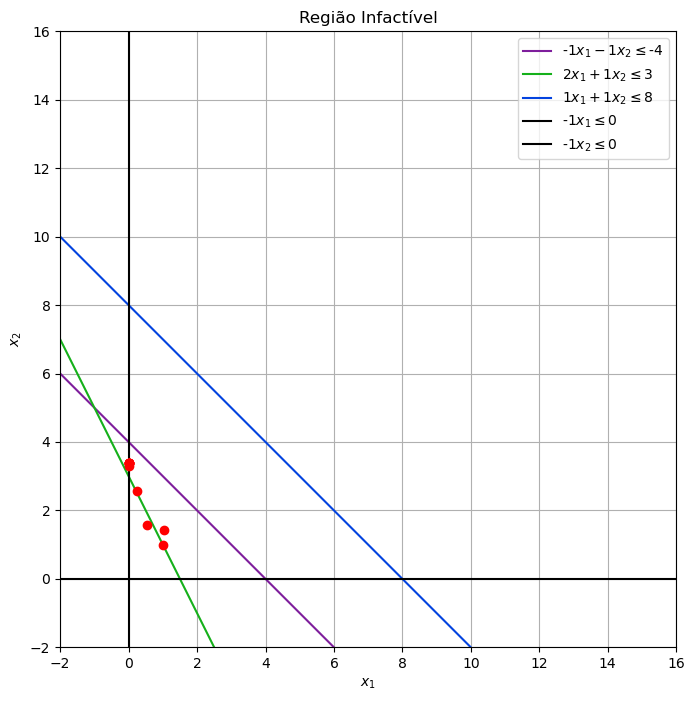

In [77]:
plot_graph(artificial_A, artificial_b, artificial_operators, solutions_list, infeasible)